In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext line_profiler
# %pdb

import os
from IPython.core.debugger import set_trace
from matplotlib import pyplot as plt
from matplotlib import gridspec
import numpy as np
import time
import scipy.stats

import h5py
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import consensus_score


import cosmos.traces.trace_analysis_utils as utils
from cosmos.behavior.bpod_dataset import BpodDataset
import cosmos.imaging.atlas_registration as reg
from cosmos.traces.cell_plotter import CellPlotter
from cosmos.traces.cosmos_traces import CosmosTraces

import cosmos.params.trace_analyze_params as params 

import matplotlib

/Users/ikauvar/opt/anaconda3/envs/cosmos3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%pdb

Automatic pdb calling has been turned ON


In [3]:
# Select dataset.
workstation = 'ikmacbook' #'analysis2'
if workstation == 'analysis2':
    data_dir = '/home/izkula/Dropbox/cosmos_data/'
    fig_save_dir = '/home/izkula/Dropbox/cosmos/trace_analysis/'
    bpod_dir = '/home/izkula/Dropbox/cosmos_data/behavior/'
elif workstation == 'cosmosdata':
    data_dir = '/home/izkula/Dropbox/cosmos_data/'
    fig_save_dir = '/home/izkula/Dropbox/cosmos/trace_analysis/'
    bpod_dir = '/home/izkula/Dropbox/cosmos_data/behavior/'
elif workstation == 'ikmacbook':
    data_dir = '/Users/ikauvar/Dropbox/cosmos_data/'
    fig_save_dir = '/Users/ikauvar/Dropbox/cosmos/trace_analysis/'
    bpod_dir = '/Users/ikauvar/Dropbox/cosmos_data/behavior/'
    
dataset_id = 38
dataset = params.DATASETS[dataset_id]
print(dataset)
dataset['data_root'] = data_dir
dataset['fig_save_dir'] = fig_save_dir
dataset['behavior_dir'] = bpod_dir

{'date': '20190502', 'name': 'm4293_1hr_resting_state_3', 'bpod_file': None, 'info': 'Spontaneous activity, 2568 sources.'}


(1/3) Loading trace data.
Bpod file not loaded: hardcoding dt.
LED trials: 495
Processing traces.
[-91.75355543 463.75355543]
[363.86868856 317.13131144]
Elapsed time: 61.3581120967865


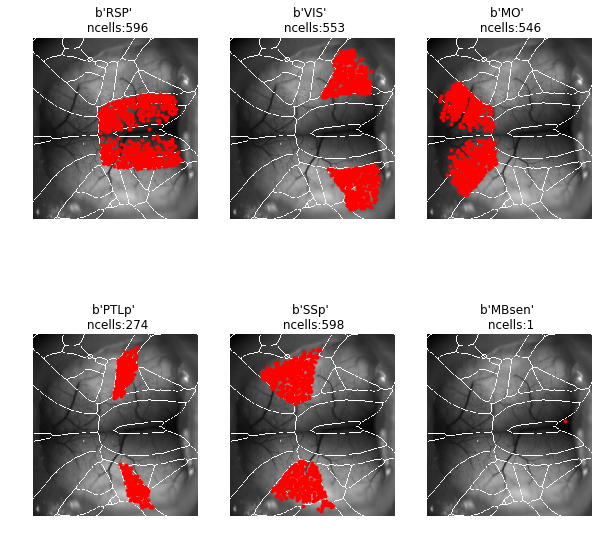

In [4]:
# Load data.
startt = time.time()

CT = CosmosTraces(dataset, do_region_plots=True)

print('Elapsed time: '+str(time.time() - startt))

# TODO : Plot atlas overlay to check that it looks good. 

In [5]:
CT.footprints.shape

(628, 567, 2568)

In [23]:
nx = CT.footprints.shape[0]
ny = CT.footprints.shape[1]
cm = 'RdYlBu_r'
sum_matrix = np.zeros((nx, ny, 4));
cmap = matplotlib.cm.get_cmap(cm)

step = 3
ordering = np.random.permutation(np.arange(1, CT.ncells, step))
for ci, fi in enumerate(ordering):
    c = cmap(ci*step/CT.ncells)
    m = np.ones((nx, ny))
    color_mat = np.dstack((m*c[0], m*c[1], m*c[2], m*c[3]))
#     color_mat[:,:,3] = 1
    f = CT.footprints[:,:,fi][:,:,np.newaxis]
    f = f/np.max(f)
    
    fmat = color_mat*f**8
    fmat[:,:,3] = 1
    sum_matrix = np.maximum(sum_matrix, fmat)
#     sum_matrix(indices where contour > 0, :) = color;

#     for color, contour = enumerate(colors, contours)
#     sum_matrix(indices where contour > 0, rgb indices) = color;
#     sum_matrix(indices where contour > 0, alpha channel) = weights;

In [24]:
I = scipy.misc.imresize(sum_matrix, 400, interp='bicubic', mode=None)
M = scipy.misc.imresize(CT.mean_image, 400, interp='bicubic', mode=None)


/Users/ikauvar/opt/anaconda3/envs/cosmos3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  """Entry point for launching an IPython kernel.
/Users/ikauvar/opt/anaconda3/envs/cosmos3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


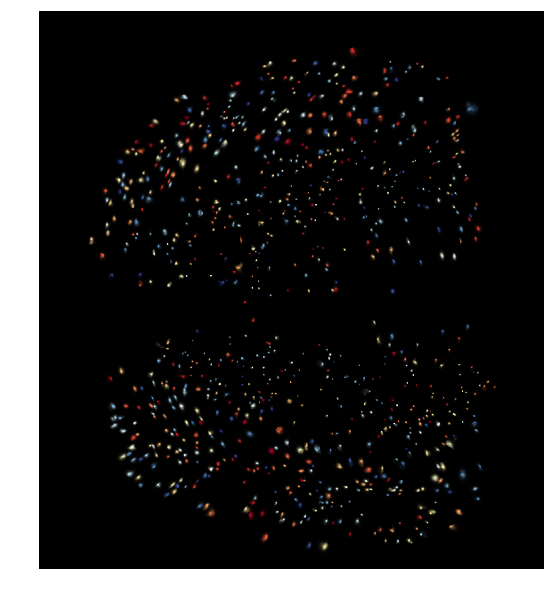

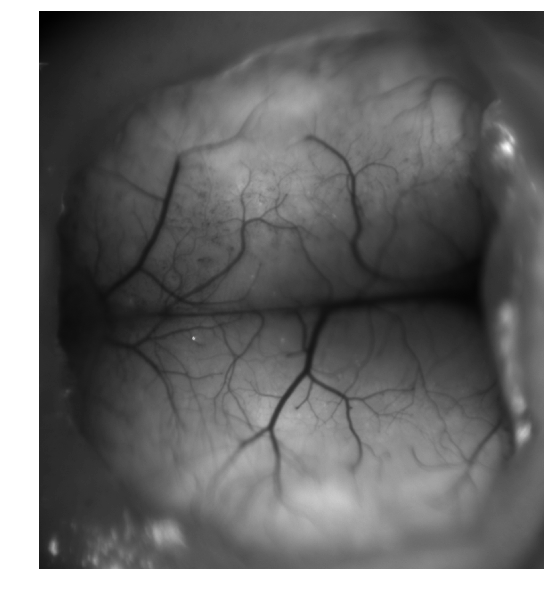

In [25]:
for i in range(2):
    fig = plt.figure(frameon=False)
    w = 7
    h = w*M.shape[0]/M.shape[1]
    fig.set_size_inches(w, h)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    if i == 0:
        ax.imshow(I)
        dpi = 300
        save_dir = '/Users/ikauvar/Dropbox/cosmos/covers/footprints'
        plt.savefig(os.path.join(save_dir, cm + '_'+str(step)+'.png'), dpi=dpi)
    if i == 1:
        ax.imshow(M, cmap='gray')
        dpi = 300
        save_dir = '/Users/ikauvar/Dropbox/cosmos/covers/footprints'
        plt.savefig(os.path.join(save_dir,'mean.png'), dpi=dpi)

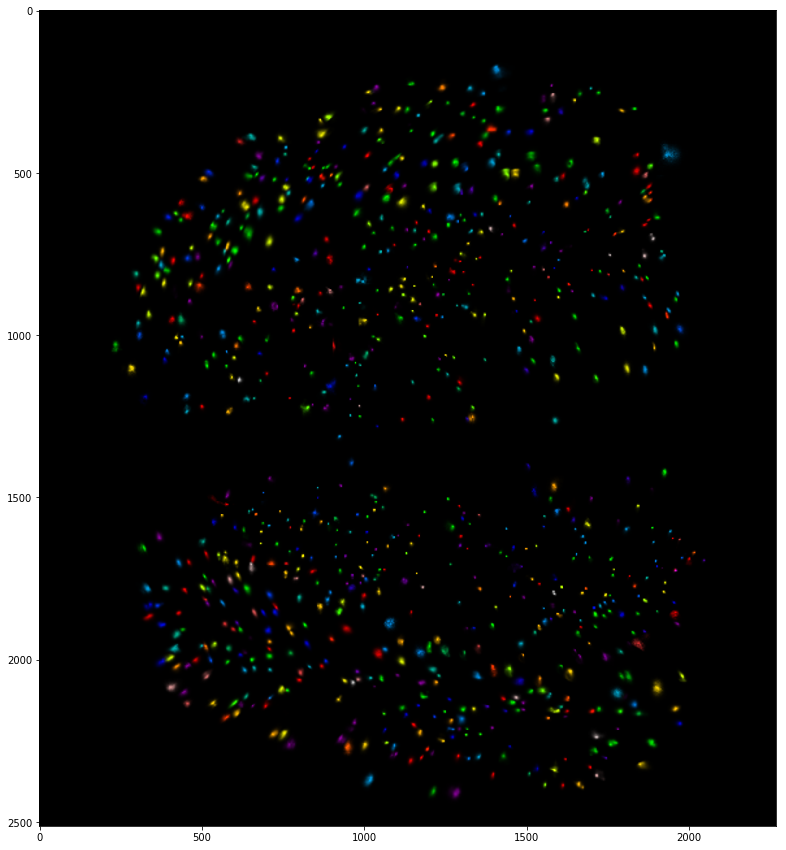

In [155]:
plt.figure(figsize=[15, 15])
plt.imshow(I)

save_dir = '/Users/ikauvar/Dropbox/cosmos/covers/footprints'
plt.savefig(os.path.join(save_dir, cm + '_'+str(step)+'.png'))

In [92]:
np.max(CT.mean_image)

61832.0

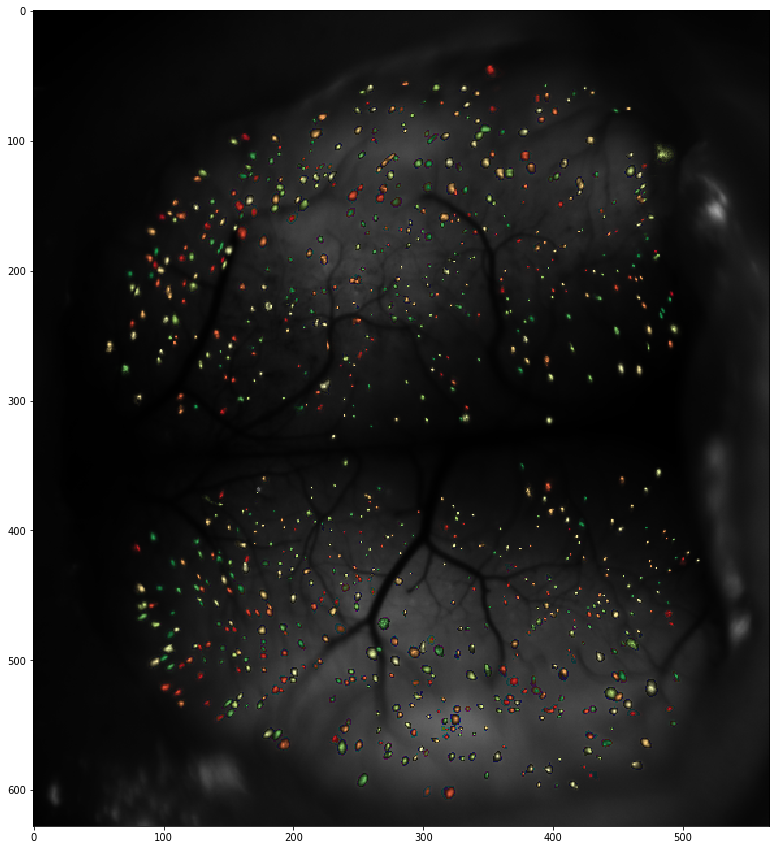

In [141]:
m = CT.mean_image
m = 0.8*m/np.max(m)
m = m**2
mm = np.dstack([m, m, m, np.zeros(m.shape)])
mm[np.where(sum_matrix>0.05)] = 0
plt.figure(figsize=[15, 15])
plt.imshow(mm+sum_matrix)


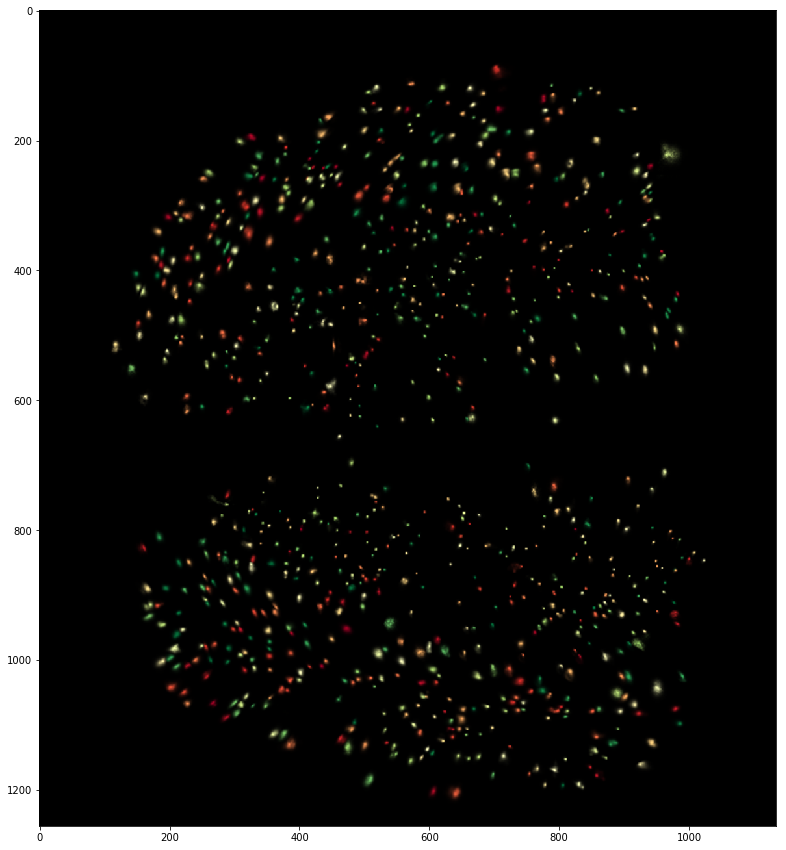

In [90]:
plt.figure(figsize=[15, 15])
plt.imshow(I)

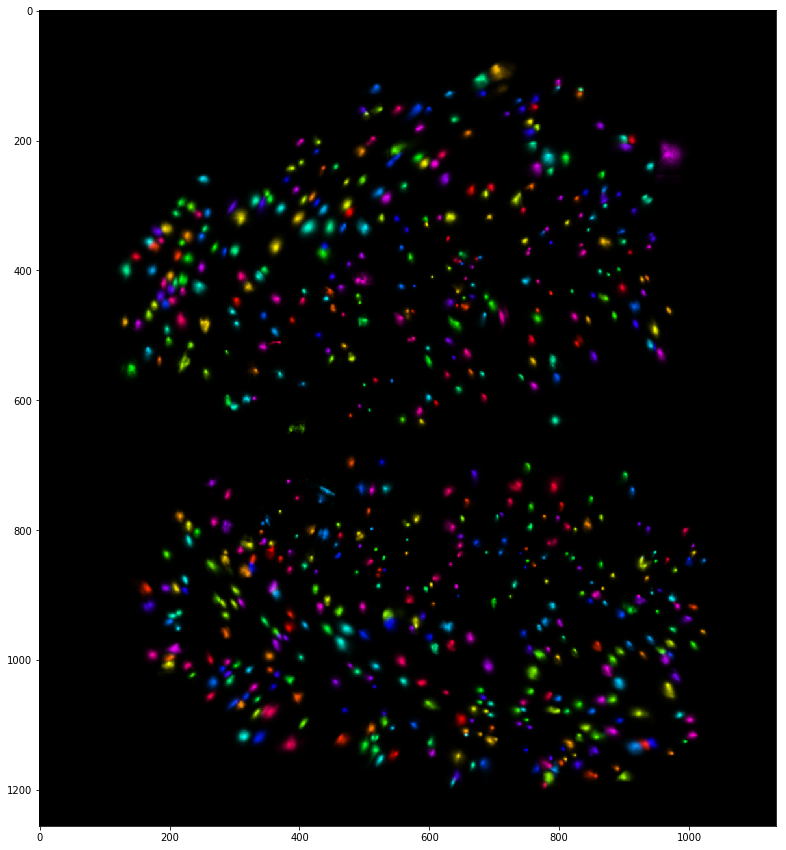

In [86]:
plt.figure(figsize=[15, 15])
plt.imshow(I)

In [ ]:


r = np.zeros(nx, ny, 4)
r[:,:,0, :] = 1
g = np.zeros(nx, ny, 4)
g[:,:,1, :] = 1
b = np.zeros(nx, ny, 4)
b[:,:,2, :] = 1
for i in range(1, CT.ncells, 20):
    plt.imshow(CT.footprints[:,:,i])

KeyboardInterrupt: 

> /Users/ikauvar/opt/anaconda3/envs/cosmos3/lib/python3.6/site-packages/matplotlib/cbook.py(1506)safe_masked_invalid()
   1504 
   1505 def safe_masked_invalid(x, copy=False):
-> 1506     x = np.array(x, subok=True, copy=copy)
   1507     if not x.dtype.isnative:
   1508         # Note that the argument to `byteswap` is 'inplace',

ipdb> quit()


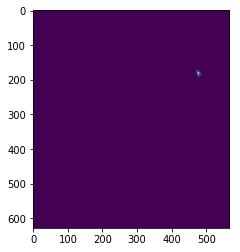

In [22]:
plt.imshow(CT.mean_image, cmap='gray')
for i in range(1, CT.ncells, 20):
    plt.imshow(CT.footprints[:,:,i])

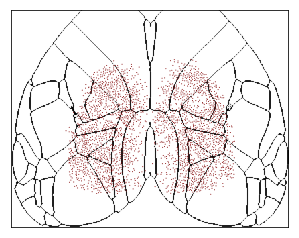

In [15]:
CT.centroids_on_atlas(np.ones(CT.ncells), np.arange(CT.ncells), max_radius=1)

In [36]:
### HERE IS THE DATA

CT.led_frames
CT.S # Spikes
CT.C # Smooth fluorescence
CT.F # Raw fluorescence

## Use smoothed spikes for analyses
smooth_spikes = gaussian_filter1d(CT.St, 1.5, axis=1, mode='constant')


In [17]:
np.shape(CT.C)

(2539, 69154)

In [8]:
# Setup some analysis specific variables.
smooth_spikes = gaussian_filter1d(CT.St, 1.5, axis=1, mode='constant')


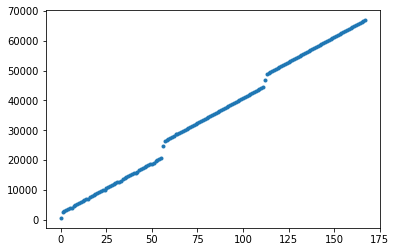

In [13]:
plt.plot(CT.led_frames, '.')

In [6]:
# Make general summary plots for specified cells and trials. 

# Select cells and regions.
region = 'MO'
hemisphere = None #0
spout_num = 1
which_cells = np.array(CT.cells_in_region[CT.regions[region]])
#which_cells = good_cells
if hemisphere is not None:
    which_cells = which_cells[np.where(CT.hemisphere_of_cell[which_cells]==hemisphere)[0]]
    
use_all_cells = True
if use_all_cells:
    which_cells = np.arange(np.shape(CT.Ct)[0])



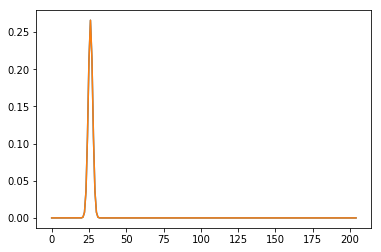

In [9]:
### Set rates here (i.e. could use fluorescence or spikes)
rates = smooth_spikes
rates_flat = np.reshape(rates, (rates.shape[0], rates.shape[1]*rates.shape[2]), order='F')

# Double check that the reshaping is correct
plt.plot(rates_flat[1,205:410])
plt.plot(rates[1,:,1])

In [8]:
# Get distance matrix so can define peers as neurons greater than some distance away.
nneurons = rates.shape[0]
distances = np.zeros((nneurons, nneurons))
for neuron in range(nneurons):
    cc = CT.centroids[neuron,:]
    diff = CT.centroids - cc
    distances[neuron,:] = np.sqrt(diff[:, 0]**2 + diff[:, 1]**2)

In [9]:
event_frames = CT.fps*np.array([0, BD.stimulus_times[0], 
                             BD.stimulus_times[0]+1.5])
print(event_frames)

[  0.          64.68288241 108.7848477 ]


In [14]:
CT.fig_save_path

'/home/izkula/Dropbox/cosmos/trace_analysis/20190522/cux2m4293_lsd_1'

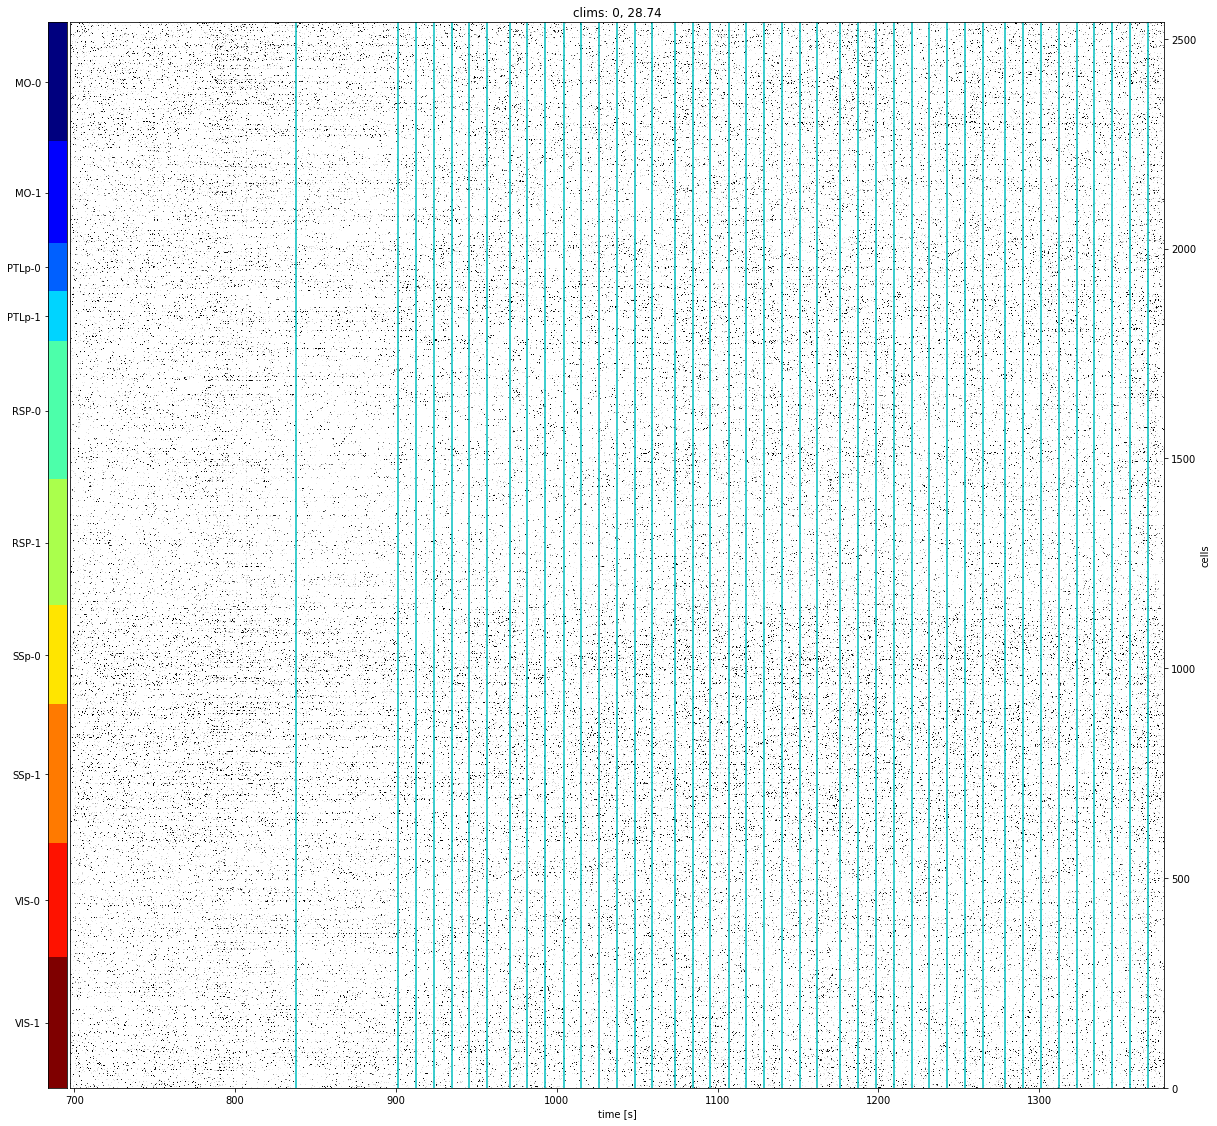

In [40]:
# CT.plot_raster_by_region(traces=gaussian_filter1d(CT.S, 0.5, axis=1), startframe=0, nframes=np.shape(CT.S)[1], event_frames=CT.led_frames)
# plt.savefig(os.path.join(CT.fig_save_path, 'raster_zoom1.pdf'), transparent=True, rasterized=True, dpi=600)
CT.plot_raster_by_region(traces=gaussian_filter1d(CT.S, 0.5, axis=1), startframe=20515, nframes=20000, event_frames=CT.led_frames)
plt.savefig(os.path.join(CT.fig_save_path, 'raster_zoom2.pdf'), transparent=True, rasterized=True, dpi=600)
# CT.plot_raster_by_region(traces=gaussian_filter1d(CT.S, 0.5, axis=1), startframe=24646, nframes=100, event_frames=CT.led_frames)
# plt.savefig(os.path.join(CT.fig_save_path, 'raster_zoom3.pdf'), transparent=True, rasterized=True, dpi=600)


In [91]:
### Get led frames for each stimulus. 

nrepeats = 5
n_per_repeat = 9

pre_gray_ind = 0
pre_inds = []
for i in range(nrepeats):
    pre_inds.append(np.arange(1,n_per_repeat+1)+n_per_repeat*i)
# pre_inds = np.concatenate(pre_inds)
pre_inds = np.vstack(pre_inds)

post1_gray_ind = 56
post1_inds = []
for i in range(nrepeats):
    post1_inds.append(np.arange(1,n_per_repeat+1)+n_per_repeat*i+post1_gray_ind)
# post1_inds = np.concatenate(post1_inds)
post1_inds = np.vstack(post1_inds)



post2_gray_ind = 112
post2_inds = []
for i in range(nrepeats):
    post2_inds.append(np.arange(1,n_per_repeat+1)+n_per_repeat*i+post2_gray_ind)
# post2_inds = np.concatenate(post2_inds)
post2_inds = np.vstack(post2_inds)


In [65]:
CT.S.shape

(2539, 69154)

In [74]:
pre_inds

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [90]:
pre_inds.shape

(5, 9)

In [96]:
### Organize data into trials etc. 

spikes = CT.S ### TODO? Gaussian filter?
w = 200 ## Frames

pre_spikes = [np.dstack([spikes[:, int(ind):int(ind)+w] for ind in pre_inds[i, :]])
              for i in range(pre_inds.shape[0])]
post1_spikes = [np.dstack([spikes[:, int(ind):int(ind)+w] for ind in post1_inds[i, :]])
                for i in range(post1_inds.shape[0])]
post2_spikes = [np.dstack([spikes[:, int(ind):int(ind)+w] for ind in post2_inds[i, :]])
                for i in range(post2_inds.shape[0])]

pre_spikes = np.stack(pre_spikes, axis=3) # neuron x time x trialtype x trialblock
post1_spikes = np.stack(post1_spikes, axis=3) # neuron x time x trialtype x trialblock
post2_spikes = np.stack(post2_spikes, axis=3) # neuron x time x trialtype x trialblock

In [127]:
### Plot cell tuning before and after LSD

trial_type = 2

pre_avg = np.mean(pre_spikes[:, :, trial_type, :], axis=2)
post1_avg = np.mean(post1_spikes[:, :, trial_type, :], axis=2)
post2_avg = np.mean(post2_spikes[:, :, trial_type, :], axis=2)

pre_avg = pre_avg - np.min(pre_avg, axis=1)[:, np.newaxis]
post1_avg = post1_avg - np.min(post1_avg, axis=1)[:, np.newaxis]
post2_avg = post2_avg - np.min(post2_avg, axis=1)[:, np.newaxis]

In [128]:
pre_avg.shape

(2539, 200)

In [129]:
save_dir = os.path.join(fig_save_dir, 'lsd', 'dataset{}'.format(dataset_id), 
                            'trialtype{}'.format(trial_type))
vid_save_dir = os.path.join(save_dir, 'pre')
os.makedirs(vid_save_dir, exist_ok=True)
utils.centroid_movie(pre_avg, np.arange(CT.S.shape[0]), CT.centroids, CT.atlas_tform, max_radius=300,
                    save_dir=vid_save_dir, do_square=True)

0...1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...99...100...101...102...103...104...105...106...107...108...109...110...111...112...113...114...115...116...117...118...119...120...121...122...123...124...125...126...127...128...129...130...131...132...133...134...135...136...137...138...139...140...141...142...143...144...145...146...147...148...149...150...151...152...153...154...155...156...157...158...159...160...161...162...163...164...165...166...167...168...169...170...171...172...173...174...175...176...177...178...179...180...181...182...183...184...

In [130]:
vid_save_dir = os.path.join(save_dir, 'post1')
os.makedirs(vid_save_dir, exist_ok=True)
utils.centroid_movie(post1_avg, np.arange(CT.S.shape[0]), CT.centroids, CT.atlas_tform, max_radius=300,
                    save_dir=vid_save_dir, do_square=True)

0...1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...99...100...101...102...103...104...105...106...107...108...109...110...111...112...113...114...115...116...117...118...119...120...121...122...123...124...125...126...127...128...129...130...131...132...133...134...135...136...137...138...139...140...141...142...143...144...145...146...147...148...149...150...151...152...153...154...155...156...157...158...159...160...161...162...163...164...165...166...167...168...169...170...171...172...173...174...175...176...177...178...179...180...181...182...183...184...

In [131]:
vid_save_dir = os.path.join(save_dir, 'post2')
os.makedirs(vid_save_dir, exist_ok=True)
utils.centroid_movie(post2_avg, np.arange(CT.S.shape[0]), CT.centroids, CT.atlas_tform, max_radius=300,
                    save_dir=vid_save_dir, do_square=True)

0...1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...99...100...101...102...103...104...105...106...107...108...109...110...111...112...113...114...115...116...117...118...119...120...121...122...123...124...125...126...127...128...129...130...131...132...133...134...135...136...137...138...139...140...141...142...143...144...145...146...147...148...149...150...151...152...153...154...155...156...157...158...159...160...161...162...163...164...165...166...167...168...169...170...171...172...173...174...175...176...177...178...179...180...181...182...183...184...

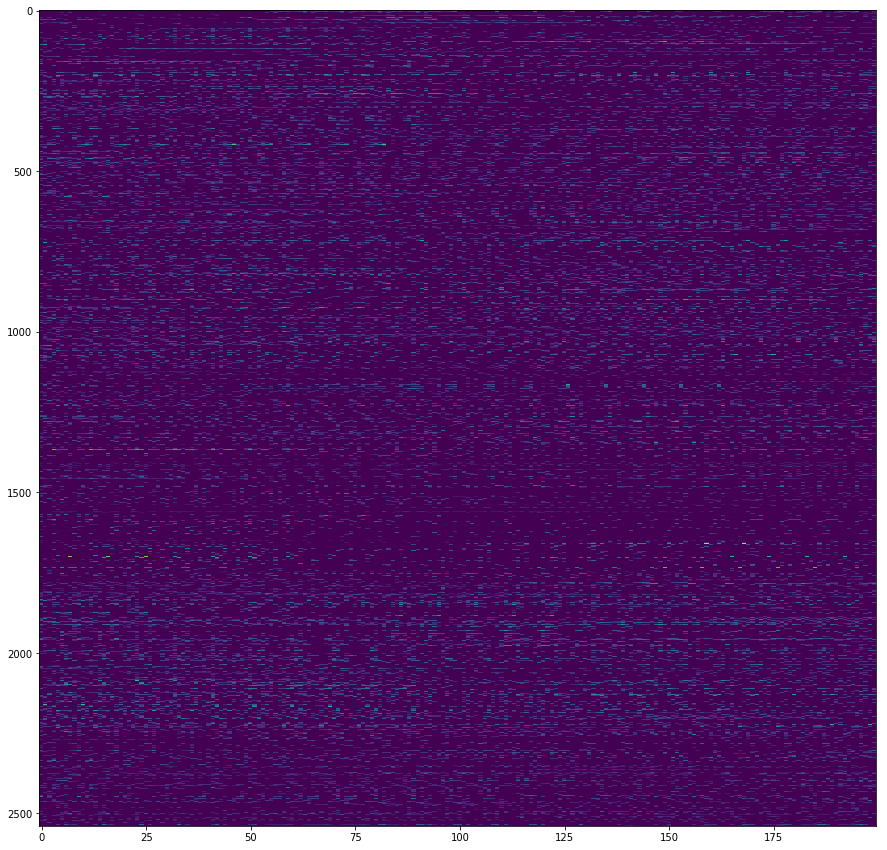

In [113]:
plt.figure(figsize=(15, 15))
plt.imshow(pre_avg, aspect='auto')

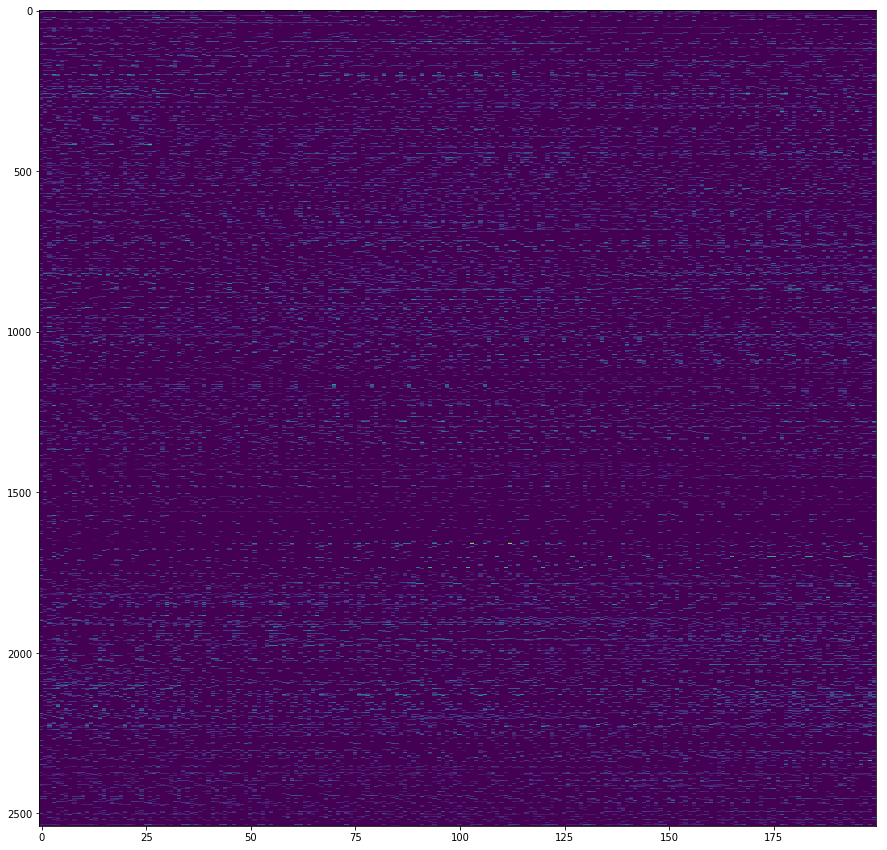

In [114]:
plt.figure(figsize=(15, 15))
plt.imshow(post1_avg, aspect='auto')

In [ ]:
### Plot frequency response (during the gray screen?)



